In [2]:
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
from hurst import compute_Hc
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import yfinance as yf
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
access_token = "9c7349b9a9bd3d17409758cb7e29e53f-7fcbdfe7bc0636788aa51f7e4a95601f"
account_id = "101-003-28600525-001"

accountID = account_id
access_token = access_token

api = API(access_token=access_token)

In [4]:
class Momentum_Hurst_RSI():

    def __init__(self, instrument, params, short_term_window, long_term_window, hurst_window ): # params: from, to, granularity
        self.instrument = instrument
        self.params = params
        self.ST_window = short_term_window
        self.LT_window = long_term_window
        # Hurst exponent
        self.hurst_window = hurst_window

        # RSI indicator, same as the short term window
        self.RSI_window = short_term_window
        self.prepare_data()
    

    def prepare_data(self):
        # Make a request
        r = instruments.InstrumentsCandles(instrument=self.instrument, params=self.params)
        data = api.request(r)

        # Extract date and closing price and form as a DataFrame
        dates = [candle['time'][:19] for candle in data['candles']]  # Intercept the first 10 characters to get the date
        close_prices = [float(candle['mid']['c']) for candle in data['candles']]  # Get Close Price

        # Create DataFrame, row_index: date; column: close price
        bt_data = pd.DataFrame(data=close_prices, index=pd.to_datetime(dates), columns=['Close_Price'])


        # Calculate the momentum and the Hurst exponent
        bt_data['ShortTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.ST_window)
        bt_data['LongTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.LT_window)    
        bt_data['Hurst'] = bt_data['Close_Price'].rolling(window=self.hurst_window).apply(lambda x: compute_Hc(x)[0])

        # Calculating the RSI
        rsi_indicator = RSIIndicator(close = bt_data['Close_Price'], window = self.RSI_window, fillna = False)
        RSI = rsi_indicator.rsi()

        # Adding the RSI to the dataframe
        bt_data['RSI'] = RSI

        # bt_data = bt_data.dropna()
        self.data = bt_data
        
    def strategy(self):
        
        data = self.data
         
        # data['Position'] = 1
        data.loc[(data['Hurst'] > 0.5) & (data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] > 0), 'Position'] = 1 # Hurst exponent greater than 0.5, short term and long term momentum greater than 0, buy
        data.loc[(data['Hurst'] > 0.5) & (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] < 0), 'Position'] = -1

        # Out of the market
        data.loc[(data['RSI'] <= 70) & (data['Hurst'] > 0.5) & ((data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] < 0) | (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] > 0)), 'Position'] = 1
        data.loc[(data['RSI'] > 70) & (data['Hurst'] > 0.5) & ((data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] < 0) | (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] > 0)), 'Position'] = -1
        data.loc[(data['Hurst'] < 0.5) & (data['RSI'] <= 70), 'Position'] = 1
        data.loc[(data['Hurst'] < 0.5) & (data['RSI'] > 70), 'Position'] = -1

        data['Signal'] = data['Position'].diff()
        data = data.dropna()

        data['Instrument_Returns'] = np.log(data['Close_Price']/data['Close_Price'].shift(1))
        data['Strategy_Returns'] = data['Instrument_Returns'] * data['Position'].shift(1)

        self.visualise_data = data
    
    def visualise_strategy(self):
        print('-------------------')
        print('Visualising the Strategy crossover period')
        bt_data = self.visualise_data
        plt.figure(figsize=(15, 5))
        plt.plot(bt_data["Close_Price"] ,color='black', label='Price', linestyle='dashed')
        plt.plot(bt_data["ShortTermMomentum"], color='b', label='Short term Momentum')
        plt.plot(bt_data["LongTermMomentum"], color='r', label='Long term Momentum')
        plt.plot(bt_data["Hurst"], color='g', label='Hurst Exponent')

        # plot ‘buy crossover’ signals.
        # Because I have used +1 and -1,
        # A buy signal will be created when the position was -1 and it turned to +1
        # difference of +1 - -1 will give me 2

        plt.plot(bt_data[bt_data['Signal'] == 2].index,
                bt_data['Close_Price'][bt_data['Signal'] == 2],
                '^', markersize = 15, color = 'g', label = 'buy/long')

        # plot ‘sell crossover ’ signals
        plt.plot(bt_data[bt_data['Signal'] == -2].index,
                bt_data['Close_Price'][bt_data['Signal'] == -2],
                'v', markersize = 15, color = 'r', label = 'sell/short')

        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.title("Moving Averages Crossover {} Vs {}".format(self.ST_window, self.LT_window))
        plt.legend()
        plt.grid()
        plt.show()

    def performance(self):

        print('-------------------')
        print('Performance of the Strategy')
        print('-------------------')

        bt_data = self.visualise_data

        daily_ret = bt_data[['Instrument_Returns', 'Strategy_Returns']].mean()
        annual_ret = daily_ret * 252
        annual_regular_ret = np.exp(annual_ret) - 1

        print('Annual Regular Return:', annual_regular_ret)

        daily_std = bt_data[['Instrument_Returns', 'Strategy_Returns']].std()
        annual_std = daily_std * math.sqrt(252)
        daily_regular_std = (np.exp(bt_data[['Instrument_Returns', 'Strategy_Returns']]) - 1).std()
        annual_regular_std = daily_regular_std * math.sqrt(252)

        print('Annual Regular Standard Deviation:', annual_regular_std)

        sr = annual_regular_ret / annual_regular_std

        print('Sharpe Ratio:', sr)

    def returns_plot(self):
        bt_data = self.visualise_data
        title = 'Returns plot for Momentum with Hurst Strategy for {} Vs {}'.format(self.ST_window, self.LT_window)
        bt_data[['Instrument_Returns', 'Strategy_Returns']].cumsum().plot(title = title, figsize=(15, 6))
        plt.show()

    def drawdown(self):
        bt_data = self.visualise_data
        bt_data['Gross_Cum_Returns'] = bt_data['Strategy_Returns'].cumsum().apply(np.exp)
        bt_data['Cum_Max'] = bt_data['Gross_Cum_Returns'].cummax()

        title = 'Drawdown for Momentum with Hurst Strategy for {} Vs {}'.format(self.ST_window, self.LT_window)
        bt_data[['Gross_Cum_Returns', 'Cum_Max']].dropna().plot(title = title, figsize=(15, 6))

        drawdown = bt_data['Cum_Max'] - bt_data['Gross_Cum_Returns']

        print('The Maximum Drawdown is:', drawdown.max())
        print('-'*20)

        zero_periods = drawdown[drawdown == 0]
        delta_values = zero_periods.index[1:] - zero_periods.index[:-1]
        print('The Longest Drawdown period is:', delta_values.max())

In [5]:
# Function to calculate annual return, annual standard deviation and Sharpe ratio for multiple instruments
def calculate_metrics(data, prefix, target_return):
    trade_windows_per_year = 252 * 24 * 60 * 60 / 5
    trade_windows_per_test = 3 * 60 * 60 / 5

    mean_return_per_trade_window = data.mean()
    annual_ret = mean_return_per_trade_window * trade_windows_per_year / trade_windows_per_test
    annual_regular_ret = np.exp(annual_ret) - 1

    std_dev_per_trade_window = data.std()
    annual_std = std_dev_per_trade_window * math.sqrt(trade_windows_per_year / trade_windows_per_test)
    
    # downside stddev
    return_diffs = (np.exp(data)-1) - target_return   #regular return
    #only care about downside part
    negative_return_diffs = return_diffs[return_diffs < 0]
    downside_std_per_trade_window = math.sqrt(np.mean(negative_return_diffs ** 2))
    annual_downside_std = downside_std_per_trade_window*math.sqrt(trade_windows_per_year / trade_windows_per_test)
    sortino_ratio_per_trade_window = (mean_return_per_trade_window - target_return) / downside_std_per_trade_window
    annual_sortino = sortino_ratio_per_trade_window*math.sqrt(trade_windows_per_year / trade_windows_per_test)

    regular_std_per_trade_window = (np.exp(data) - 1).std()
    annual_regular_std = regular_std_per_trade_window * math.sqrt(trade_windows_per_year / trade_windows_per_test)

    sr = annual_regular_ret / annual_regular_std

    print(f'Annual Regular Return ({prefix}):', annual_regular_ret)
    print(f'Annual Regular Standard Deviation ({prefix}):', annual_regular_std)
    print(f'Annual Regular Downside Standard Deviation Under Target Return={target_return} ({prefix}):', annual_downside_std)
    print(f'Sharpe Ratio ({prefix}):', sr)
    print(f'Sortino Ratio ({prefix}):', annual_sortino)
    print("-----")

-------------------
Running the Strategy for: EUR_USD
-------------------
Annual Regular Return (Instrument Returns): 0.0017609748094680189
Annual Regular Standard Deviation (Instrument Returns): 0.0012174442219762024
Annual Regular Downside Standard Deviation Under Target Return=0 (Instrument Returns): 0.0014409735060033266
Sharpe Ratio (Instrument Returns): 1.4464521476060206
Sortino Ratio (Instrument Returns): 1.22099823756471
-----
Annual Regular Return (Strategy Returns): 0.00013850979648744044
Annual Regular Standard Deviation (Strategy Returns): 0.0012180737530611157
Annual Regular Downside Standard Deviation Under Target Return=0 (Strategy Returns): 0.0014216310007432959
Sharpe Ratio (Strategy Returns): 0.11371215916881418
Sortino Ratio (Strategy Returns): 0.09742345574826651
-----


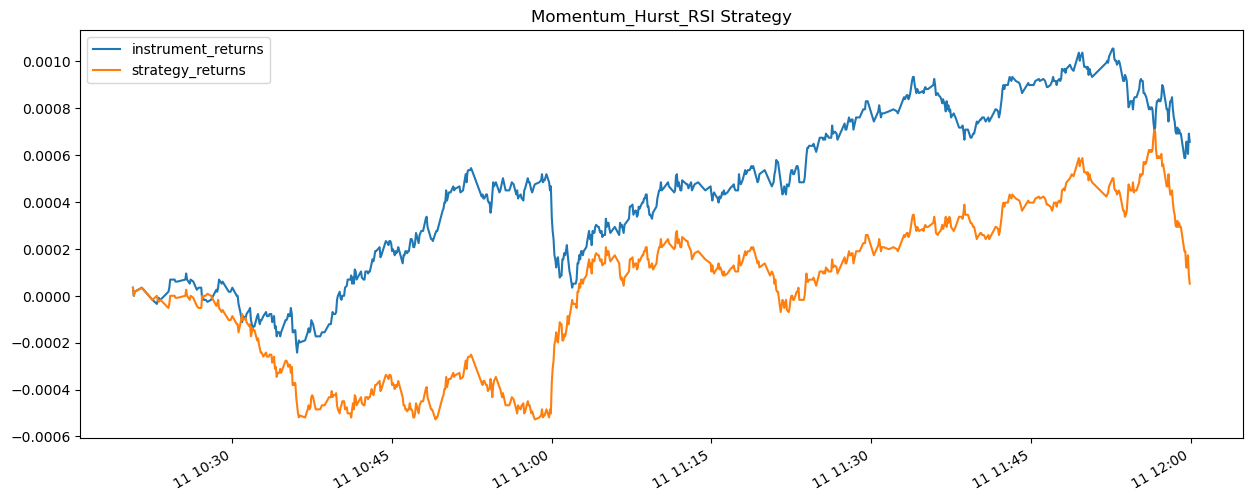

In [6]:
instruments_lis = "EUR_USD"
params = {
    "from": "2021-10-11T10:00:00Z",  # start time
    "to": "2021-10-11T12:00:00Z",  # end time
    "granularity": "S5",  # Second-level data
    "price":"M"
}
results = pd.DataFrame()

print('-------------------')
print('Running the Strategy for:', instruments_lis)
print('-------------------')
momentum_hurst_rsi = Momentum_Hurst_RSI(instruments_lis, params, 5, 21, 200)
t = momentum_hurst_rsi.data
momentum_hurst_rsi.strategy()
results['instrument_returns']=momentum_hurst_rsi.visualise_data['Instrument_Returns']
results['strategy_returns'] = momentum_hurst_rsi.visualise_data['Strategy_Returns']

plot_title = 'Momentum_Hurst_RSI Strategy'

results.cumsum().plot(title=plot_title, figsize=(15, 6))

calculate_metrics(results['instrument_returns'], 'Instrument Returns', 0)
calculate_metrics(results['strategy_returns'], 'Strategy Returns', 0)


after trying different backtesting periods, the original strategy doesn't work well so we make some adjustments

# Strategy Improvement: Combine Bollinger Bands

First we use 0.5 as the Hurst threshold to determine the trend. 
Use some sample periods to get the performance metrics and strategy results.

In [7]:
class Momentum_Hurst_RSI_BB_tune():

    def __init__(self, instrument, params, short_term_window, long_term_window, hurst_window,window, window_dev ): # params: from, to, granularity
        self.instrument = instrument
        self.params = params
        self.ST_window = short_term_window
        self.LT_window = long_term_window
        # Hurst exponent
        self.hurst_window = hurst_window

        # RSI indicator, same as the short term window
        self.RSI_window = short_term_window
        self.window = window
        self.window_dev = window_dev
        self.prepare_data()
    

    def prepare_data(self):
        # Make a request
        r = instruments.InstrumentsCandles(instrument=self.instrument, params=self.params)
        data = api.request(r)

        # Extract date and closing price and form as a DataFrame
        dates = [candle['time'][:19] for candle in data['candles']]  # Intercept the first 10 characters to get the date
        close_prices = [float(candle['mid']['c']) for candle in data['candles']]  # Get Close Price

        # Create DataFrame, row_index: date; column: close price
        bt_data = pd.DataFrame(data=close_prices, index=pd.to_datetime(dates), columns=['Close_Price'])


        # Calculate the momentum and the Hurst exponent
        bt_data['ShortTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.ST_window)
        bt_data['LongTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.LT_window)    
        bt_data['Hurst'] = bt_data['Close_Price'].rolling(window=self.hurst_window).apply(lambda x: compute_Hc(x)[0])

        # Calculating the RSI
        rsi_indicator = RSIIndicator(close = bt_data['Close_Price'], window = self.RSI_window, fillna = False)
        RSI = rsi_indicator.rsi()

        # Adding the RSI to the dataframe
        bt_data['RSI'] = RSI

        # Calculate the Bollinger Bands
        BB =  BollingerBands(close=bt_data['Close_Price'], window=self.window, window_dev=self.window_dev)
        bt_data['UB'] = BB.bollinger_hband() # upper band
        bt_data['MB'] = BB.bollinger_mavg()
        bt_data['LB'] = BB.bollinger_lband() # lower band

        bt_data = bt_data.dropna()
        self.data = bt_data
        
    def strategy(self):
        
        data = self.data

        # add 0 to the position column
        data['Position'] = 0
         
        # data['Position'] = 1
        data.loc[(data['Hurst'] > 0.5) & (data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] > 0), 'Position'] = 1 # Hurst exponent greater than 0.5, short term and long term momentum greater than 0, buy
        data.loc[(data['Hurst'] > 0.5) & (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] < 0), 'Position'] = -1

        # Out of the market, RSI less than 60
        data.loc[(data['Close_Price'] <= data['UB']) & (0.5 <= data['Hurst']) & (data['Hurst'] <= 0.5), 'Position'] = 1
        data.loc[(data['Close_Price'] > data['UB']) & (0.5 <= data['Hurst']) & (data['Hurst'] <= 0.5), 'Position'] = -1

        # Hurst less than 0.5, opposite of the above
        data.loc[(data['Hurst'] < 0.5) & (data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] > 0), 'Position'] = -1 # Hurst exponent greater than 0.5, short term and long term momentum greater than 0, buy
        data.loc[(data['Hurst'] < 0.5) & (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] < 0), 'Position'] = 1

        

        data['Signal'] = data['Position'].diff()
        data = data.dropna()

        data['Instrument_Returns'] = np.log(data['Close_Price']/data['Close_Price'].shift(1))
        data['Strategy_Returns'] = data['Instrument_Returns'] * data['Position'].shift(1)

        self.visualise_data = data

    def visualise_strategy(self):
        print('-------------------')
        print('Visualising the Strategy crossover period')
        bt_data = self.visualise_data
        plt.figure(figsize=(15, 5))
        plt.plot(bt_data["Close_Price"] ,color='black', label='Price', linestyle='dashed')
        plt.plot(bt_data["ShortTermMomentum"], color='b', label='Short term Momentum')
        plt.plot(bt_data["LongTermMomentum"], color='r', label='Long term Momentum')
        plt.plot(bt_data["Hurst"], color='g', label='Hurst Exponent')

        # plot ‘buy crossover’ signals.
        # Because I have used +1 and -1,
        # A buy signal will be created when the position was -1 and it turned to +1
        # difference of +1 - -1 will give me 2

        plt.plot(bt_data[bt_data['Signal'] == 2].index,
                bt_data['Close_Price'][bt_data['Signal'] == 2],
                '^', markersize = 15, color = 'g', label = 'buy/long')

        # plot ‘sell crossover ’ signals
        plt.plot(bt_data[bt_data['Signal'] == -2].index,
                bt_data['Close_Price'][bt_data['Signal'] == -2],
                'v', markersize = 15, color = 'r', label = 'sell/short')

        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.title("Moving Averages Crossover {} Vs {}".format(self.ST_window, self.LT_window))
        plt.legend()
        plt.grid()
        plt.show()

    def performance(self):

        print('-------------------')
        print('Performance of the Strategy')
        print('-------------------')

        bt_data = self.visualise_data

        daily_ret = bt_data[['Instrument_Returns', 'Strategy_Returns']].mean()
        annual_ret = daily_ret * 252
        annual_regular_ret = np.exp(annual_ret) - 1

        print('Annual Regular Return:', annual_regular_ret)

        daily_std = bt_data[['Instrument_Returns', 'Strategy_Returns']].std()
        annual_std = daily_std * math.sqrt(252)
        daily_regular_std = (np.exp(bt_data[['Instrument_Returns', 'Strategy_Returns']]) - 1).std()
        annual_regular_std = daily_regular_std * math.sqrt(252)

        print('Annual Regular Standard Deviation:', annual_regular_std)

        sr = annual_regular_ret / annual_regular_std

        print('Sharpe Ratio:', sr)

    def returns_plot(self):
        bt_data = self.visualise_data
        title = 'Returns plot for Momentum with Hurst Strategy for {} Vs {}'.format(self.ST_window, self.LT_window)
        bt_data[['Instrument_Returns', 'Strategy_Returns']].cumsum().plot(title = title, figsize=(15, 6))
        plt.show()

    def drawdown(self):
        bt_data = self.visualise_data
        bt_data['Gross_Cum_Returns'] = bt_data['Strategy_Returns'].cumsum().apply(np.exp)
        bt_data['Cum_Max'] = bt_data['Gross_Cum_Returns'].cummax()

        title = 'Drawdown for Momentum with Hurst Strategy for {} Vs {}'.format(self.ST_window, self.LT_window)
        bt_data[['Gross_Cum_Returns', 'Cum_Max']].dropna().plot(title = title, figsize=(15, 6))

        drawdown = bt_data['Cum_Max'] - bt_data['Gross_Cum_Returns']

        print('The Maximum Drawdown is:', drawdown.max())
        print('-'*20)

        zero_periods = drawdown[drawdown == 0]
        delta_values = zero_periods.index[1:] - zero_periods.index[:-1]
        print('The Longest Drawdown period is:', delta_values.max())  

-------------------
Running the Strategy for period: 1
From: 2015-10-07T00:00:00Z, To: 2015-10-07T03:00:00Z
-------------------
Annual Regular Return (Instrument Returns): 0.001479932774155257
Annual Regular Standard Deviation (Instrument Returns): 0.0020701255348803686
Annual Regular Downside Standard Deviation Under Target Return=0 (Instrument Returns): 0.002344488733329027
Sharpe Ratio (Instrument Returns): 0.714900014138892
Sortino Ratio (Instrument Returns): 0.6307723862675901
-----
Annual Regular Return (Strategy Returns): 0.007858761058707975
Annual Regular Standard Deviation (Strategy Returns): 0.0017041213406517838
Annual Regular Downside Standard Deviation Under Target Return=0 (Strategy Returns): 0.00223620958768351
Sharpe Ratio (Strategy Returns): 4.6116205878286785
Sortino Ratio (Strategy Returns): 3.5005850424461666
-----
-------------------
Running the Strategy for period: 2
From: 2016-10-07T00:00:00Z, To: 2016-10-07T03:00:00Z
-------------------
Annual Regular Return (I

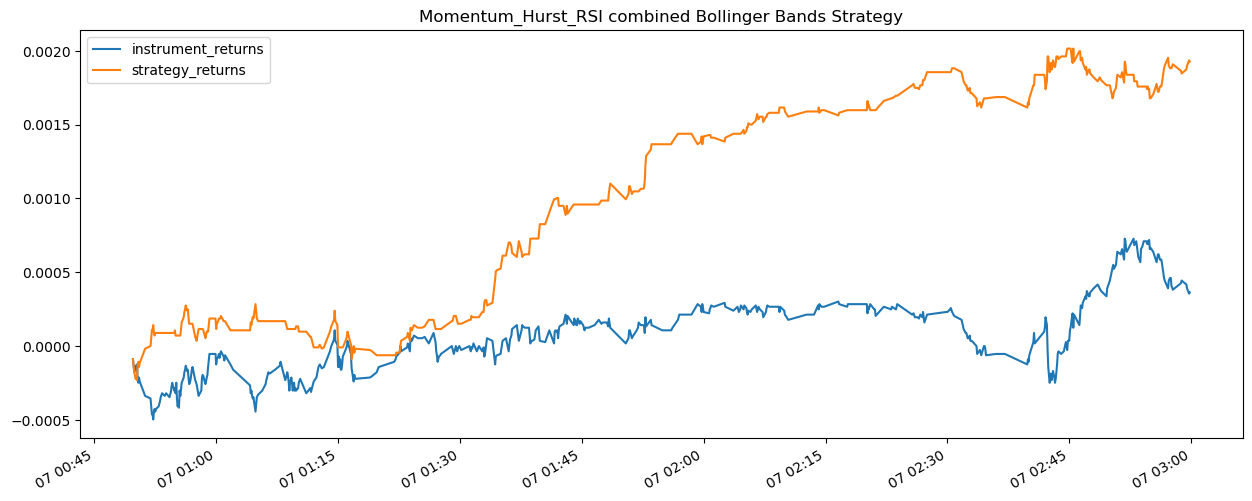

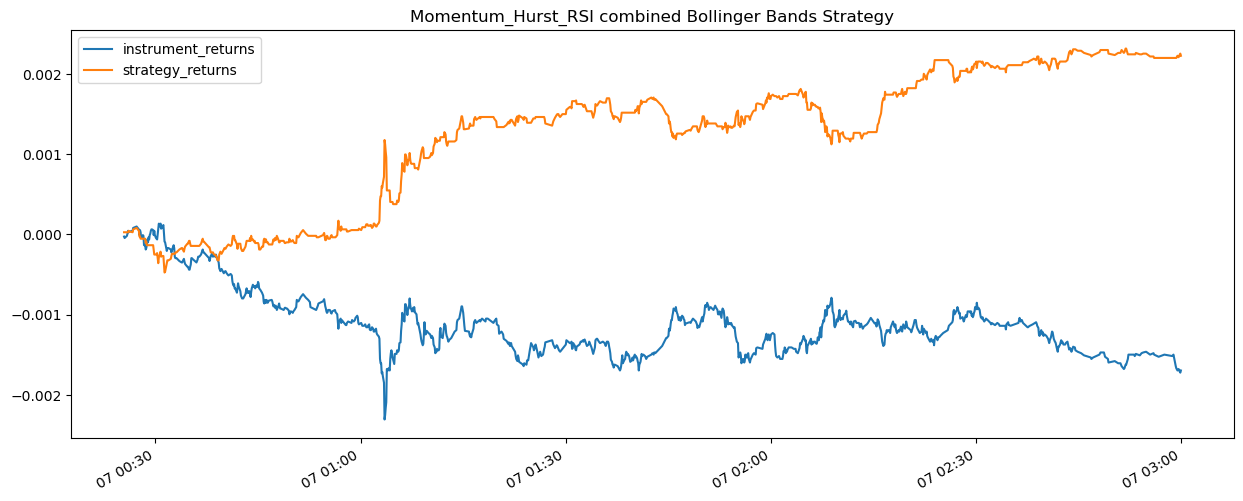

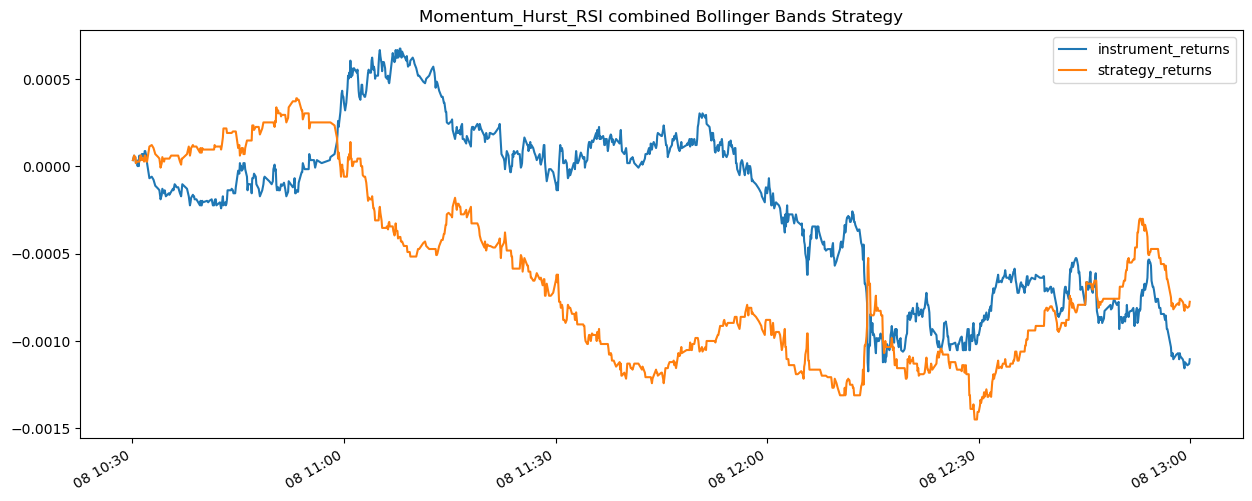

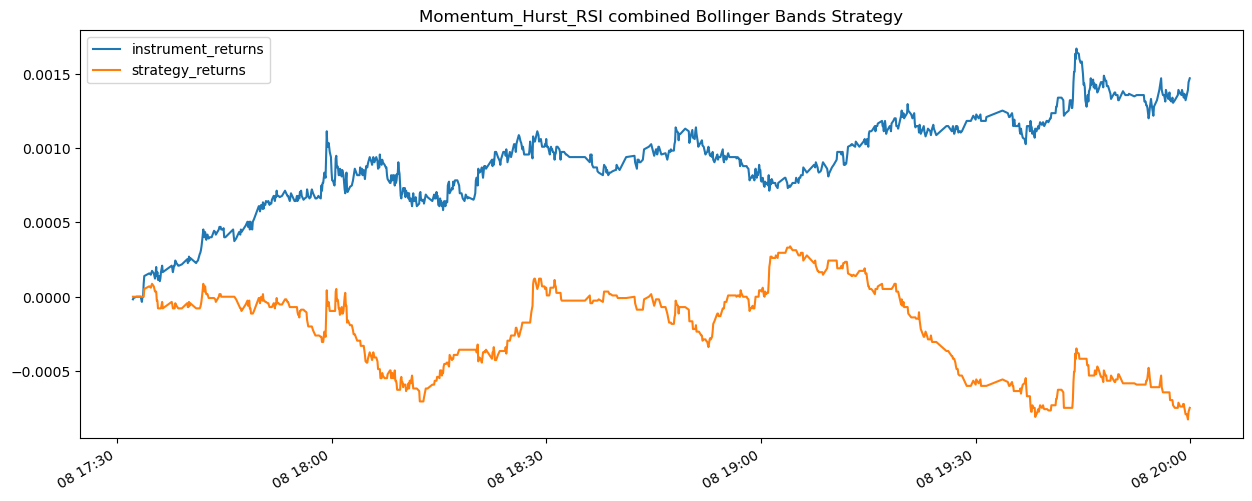

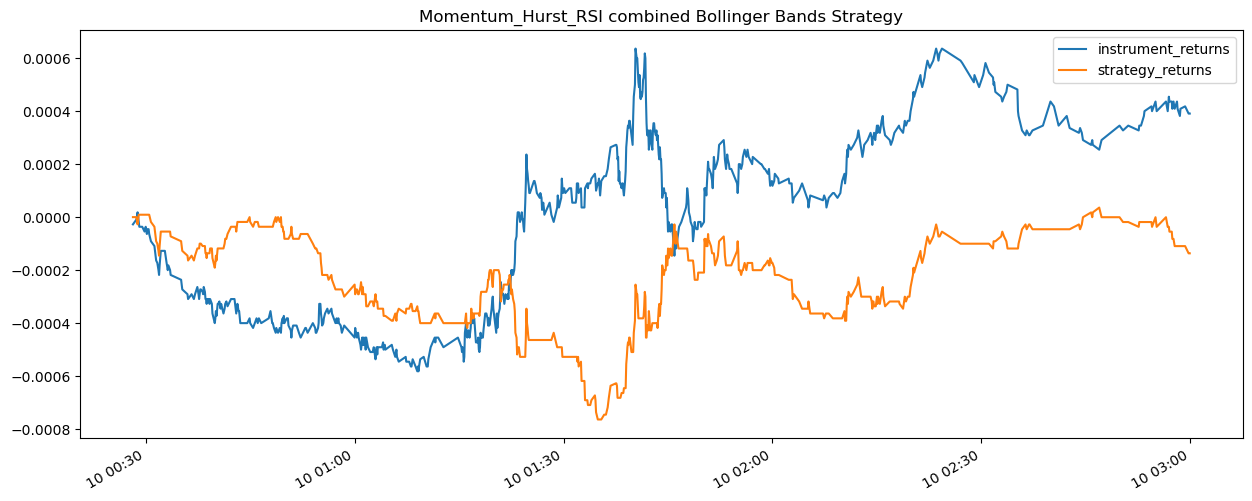

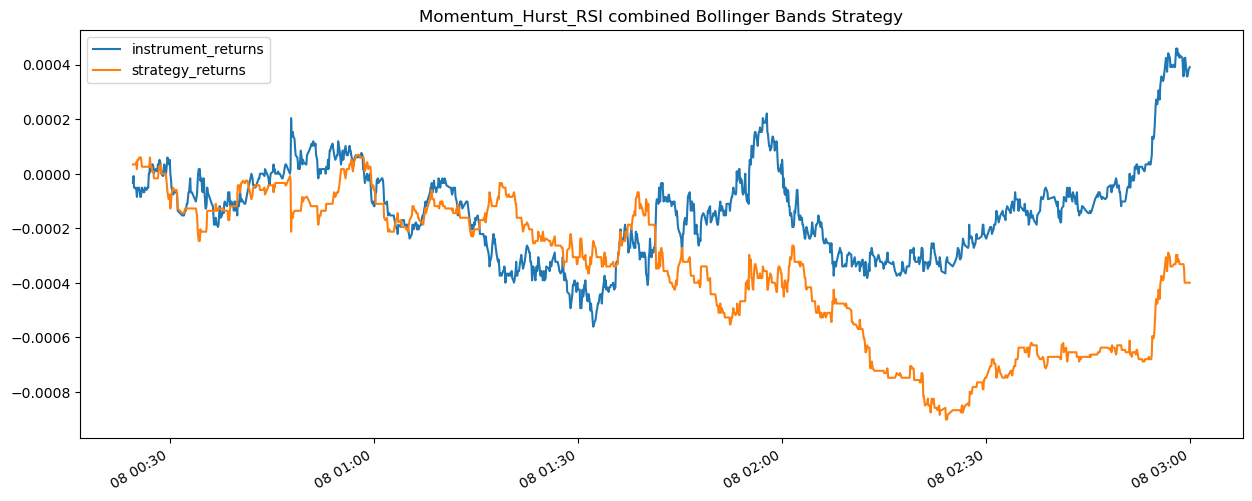

In [8]:
# Use multiple periods to do backtest
time_periods = [
    {"from": "2015-10-07T00:00:00Z", "to": "2015-10-07T03:00:00Z"},
    {"from": "2016-10-07T00:00:00Z", "to": "2016-10-07T03:00:00Z"},
    {"from": "2017-11-08T10:00:00Z", "to": "2017-11-08T13:00:00Z"},
    {"from": "2018-10-08T17:00:00Z", "to": "2018-10-08T20:00:00Z"},
    {"from": "2019-10-10T00:00:00Z", "to": "2019-10-10T03:00:00Z"},
    {"from": "2020-10-08T00:00:00Z", "to": "2020-10-08T03:00:00Z"},

    # can add more periods to backtest
]

# Keep other parameters unchanged
instrument = "EUR_USD"
granularity = "S5"
price = "M"


for i, period in enumerate(time_periods):
    results = pd.DataFrame()

    print('-------------------')
    print(f'Running the Strategy for period: {i+1}')
    print(f"From: {period['from']}, To: {period['to']}")
    print('-------------------')
    
    # update params
    params = {
        "from": period['from'],
        "to": period['to'],
        "granularity": "S5",
        "price": 'M'
    }
    
    momentum_hurst_rsi_bb = Momentum_Hurst_RSI_BB_tune(instrument, params, 5, 21, 200, 20, 0.8)
    momentum_hurst_rsi_bb.strategy()
    


    results[f'instrument_returns'] = momentum_hurst_rsi_bb.visualise_data['Instrument_Returns']
    results[f'strategy_returns'] = momentum_hurst_rsi_bb.visualise_data['Strategy_Returns']

    results['instrument_returns'] = pd.to_numeric(results['instrument_returns'], errors='coerce')
    results['strategy_returns'] = pd.to_numeric(results['strategy_returns'], errors='coerce')


    plot_title = 'Momentum_Hurst_RSI combined Bollinger Bands Strategy'
    results.cumsum().plot(title=plot_title, figsize=(15, 6))

    calculate_metrics(results['instrument_returns'], 'Instrument Returns', 0)
    calculate_metrics(results['strategy_returns'], 'Strategy Returns', 0)
    

For the six backtesting periods, only two periods the strategy performs better than the instrument and gained profits.

We then try different parameters on the six backtesting periods and in order to save the page, we didn't list all the tuning results and you can simply modify the code in **"strategy" function** to see the results for different parameters.

**parameters = 0.8** gives the best performance and is listed below:

In [9]:
class Momentum_Hurst_RSI_BB():

    def __init__(self, instrument, params, short_term_window, long_term_window, hurst_window,window, window_dev ): # params: from, to, granularity
        self.instrument = instrument
        self.params = params
        self.ST_window = short_term_window
        self.LT_window = long_term_window
        # Hurst exponent
        self.hurst_window = hurst_window

        # RSI indicator, same as the short term window
        self.RSI_window = short_term_window
        self.window = window
        self.window_dev = window_dev
        self.prepare_data()
    

    def prepare_data(self):
        # Make a request
        r = instruments.InstrumentsCandles(instrument=self.instrument, params=self.params)
        data = api.request(r)

        # Extract date and closing price and form as a DataFrame
        dates = [candle['time'][:19] for candle in data['candles']]  # Intercept the first 10 characters to get the date
        close_prices = [float(candle['mid']['c']) for candle in data['candles']]  # Get Close Price

        # Create DataFrame, row_index: date; column: close price
        bt_data = pd.DataFrame(data=close_prices, index=pd.to_datetime(dates), columns=['Close_Price'])


        # Calculate the momentum and the Hurst exponent
        bt_data['ShortTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.ST_window)
        bt_data['LongTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.LT_window)    
        bt_data['Hurst'] = bt_data['Close_Price'].rolling(window=self.hurst_window).apply(lambda x: compute_Hc(x)[0])

        # Calculating the RSI
        rsi_indicator = RSIIndicator(close = bt_data['Close_Price'], window = self.RSI_window, fillna = False)
        RSI = rsi_indicator.rsi()

        # Adding the RSI to the dataframe
        bt_data['RSI'] = RSI

        # Calculate the Bollinger Bands
        BB =  BollingerBands(close=bt_data['Close_Price'], window=self.window, window_dev=self.window_dev)
        bt_data['UB'] = BB.bollinger_hband() # upper band
        bt_data['MB'] = BB.bollinger_mavg()
        bt_data['LB'] = BB.bollinger_lband() # lower band

        bt_data = bt_data.dropna()
        self.data = bt_data
        
    def strategy(self):
        
        data = self.data

        # add 0 to the position column
        data['Position'] = 0
         
        # data['Position'] = 1
        data.loc[(data['Hurst'] > 0.8) & (data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] > 0), 'Position'] = 1 # Hurst exponent greater than 0.5, short term and long term momentum greater than 0, buy
        data.loc[(data['Hurst'] > 0.8) & (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] < 0), 'Position'] = -1

        # Out of the market, RSI less than 60
        data.loc[(data['Close_Price'] <= data['UB']) & (0.2 <= data['Hurst']) & (data['Hurst'] <= 0.8), 'Position'] = 1
        data.loc[(data['Close_Price'] > data['UB']) & (0.2 <= data['Hurst']) & (data['Hurst'] <= 0.8), 'Position'] = -1

        # Hurst less than 0.5, opposite of the above
        data.loc[(data['Hurst'] < 0.2) & (data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] > 0), 'Position'] = -1 # Hurst exponent greater than 0.5, short term and long term momentum greater than 0, buy
        data.loc[(data['Hurst'] < 0.2) & (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] < 0), 'Position'] = 1

        

        data['Signal'] = data['Position'].diff()
        data = data.dropna()

        data['Instrument_Returns'] = np.log(data['Close_Price']/data['Close_Price'].shift(1))
        data['Strategy_Returns'] = data['Instrument_Returns'] * data['Position'].shift(1)

        self.visualise_data = data

    def visualise_strategy(self):
        print('-------------------')
        print('Visualising the Strategy crossover period')
        bt_data = self.visualise_data
        plt.figure(figsize=(15, 5))
        plt.plot(bt_data["Close_Price"] ,color='black', label='Price', linestyle='dashed')
        plt.plot(bt_data["ShortTermMomentum"], color='b', label='Short term Momentum')
        plt.plot(bt_data["LongTermMomentum"], color='r', label='Long term Momentum')
        plt.plot(bt_data["Hurst"], color='g', label='Hurst Exponent')

        # plot ‘buy crossover’ signals.
        # Because I have used +1 and -1,
        # A buy signal will be created when the position was -1 and it turned to +1
        # difference of +1 - -1 will give me 2

        plt.plot(bt_data[bt_data['Signal'] == 2].index,
                bt_data['Close_Price'][bt_data['Signal'] == 2],
                '^', markersize = 15, color = 'g', label = 'buy/long')

        # plot ‘sell crossover ’ signals
        plt.plot(bt_data[bt_data['Signal'] == -2].index,
                bt_data['Close_Price'][bt_data['Signal'] == -2],
                'v', markersize = 15, color = 'r', label = 'sell/short')

        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.title("Moving Averages Crossover {} Vs {}".format(self.ST_window, self.LT_window))
        plt.legend()
        plt.grid()
        plt.show()

    def performance(self):

        print('-------------------')
        print('Performance of the Strategy')
        print('-------------------')

        bt_data = self.visualise_data

        daily_ret = bt_data[['Instrument_Returns', 'Strategy_Returns']].mean()
        annual_ret = daily_ret * 252
        annual_regular_ret = np.exp(annual_ret) - 1

        print('Annual Regular Return:', annual_regular_ret)

        daily_std = bt_data[['Instrument_Returns', 'Strategy_Returns']].std()
        annual_std = daily_std * math.sqrt(252)
        daily_regular_std = (np.exp(bt_data[['Instrument_Returns', 'Strategy_Returns']]) - 1).std()
        annual_regular_std = daily_regular_std * math.sqrt(252)

        print('Annual Regular Standard Deviation:', annual_regular_std)

        sr = annual_regular_ret / annual_regular_std

        print('Sharpe Ratio:', sr)

    def returns_plot(self):
        bt_data = self.visualise_data
        title = 'Returns plot for Momentum with Hurst Strategy for {} Vs {}'.format(self.ST_window, self.LT_window)
        bt_data[['Instrument_Returns', 'Strategy_Returns']].cumsum().plot(title = title, figsize=(15, 6))
        plt.show()

    def drawdown(self):
        bt_data = self.visualise_data
        bt_data['Gross_Cum_Returns'] = bt_data['Strategy_Returns'].cumsum().apply(np.exp)
        bt_data['Cum_Max'] = bt_data['Gross_Cum_Returns'].cummax()

        title = 'Drawdown for Momentum with Hurst Strategy for {} Vs {}'.format(self.ST_window, self.LT_window)
        bt_data[['Gross_Cum_Returns', 'Cum_Max']].dropna().plot(title = title, figsize=(15, 6))

        drawdown = bt_data['Cum_Max'] - bt_data['Gross_Cum_Returns']

        print('The Maximum Drawdown is:', drawdown.max())
        print('-'*20)

        zero_periods = drawdown[drawdown == 0]
        delta_values = zero_periods.index[1:] - zero_periods.index[:-1]
        print('The Longest Drawdown period is:', delta_values.max())  

-------------------
Running the Strategy for period: 1
From: 2015-10-07T00:00:00Z, To: 2015-10-07T03:00:00Z
-------------------
Annual Regular Return (Instrument Returns): 0.001479932774155257
Annual Regular Standard Deviation (Instrument Returns): 0.0020701255348803686
Annual Regular Downside Standard Deviation Under Target Return=0 (Instrument Returns): 0.002344488733329027
Sharpe Ratio (Instrument Returns): 0.714900014138892
Sortino Ratio (Instrument Returns): 0.6307723862675901
-----
Annual Regular Return (Strategy Returns): 0.010407753407502218
Annual Regular Standard Deviation (Strategy Returns): 0.002057506604309967
Annual Regular Downside Standard Deviation Under Target Return=0 (Strategy Returns): 0.002157507659229385
Sharpe Ratio (Strategy Returns): 5.058430133687325
Sortino Ratio (Strategy Returns): 4.799040032349885
-----
-------------------
Running the Strategy for period: 2
From: 2016-10-07T00:00:00Z, To: 2016-10-07T03:00:00Z
-------------------
Annual Regular Return (Ins

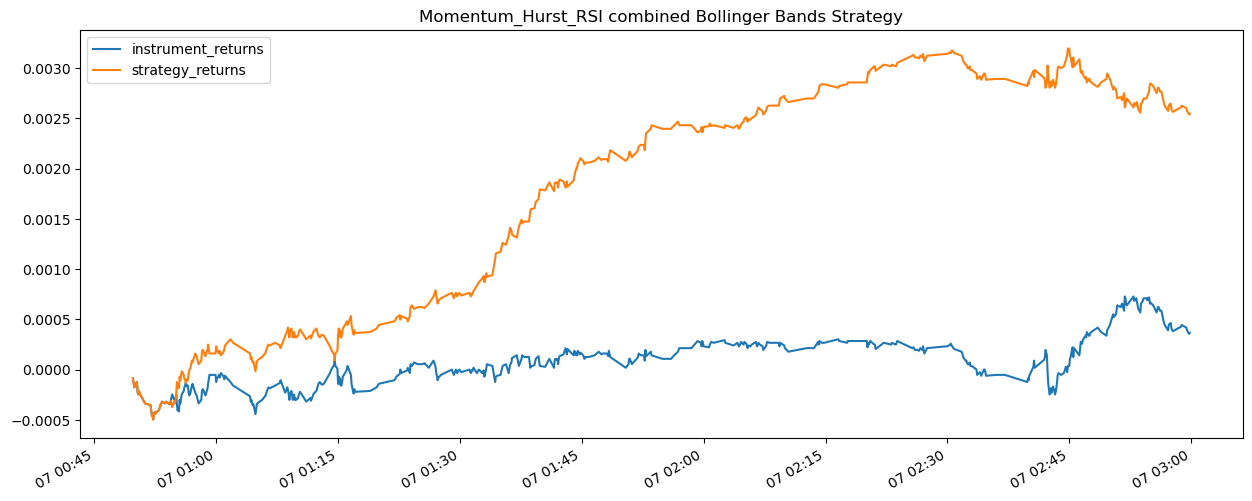

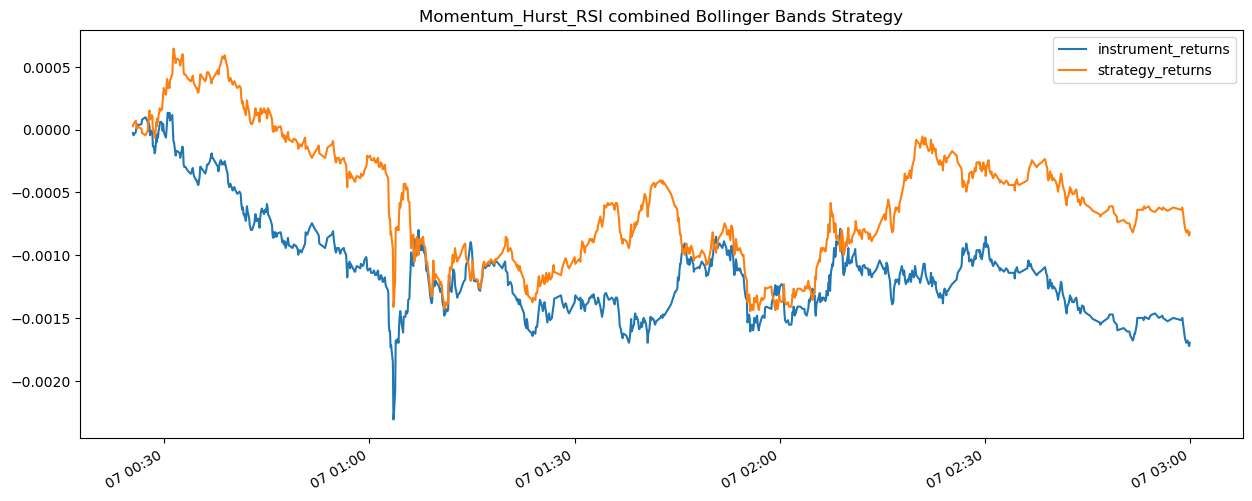

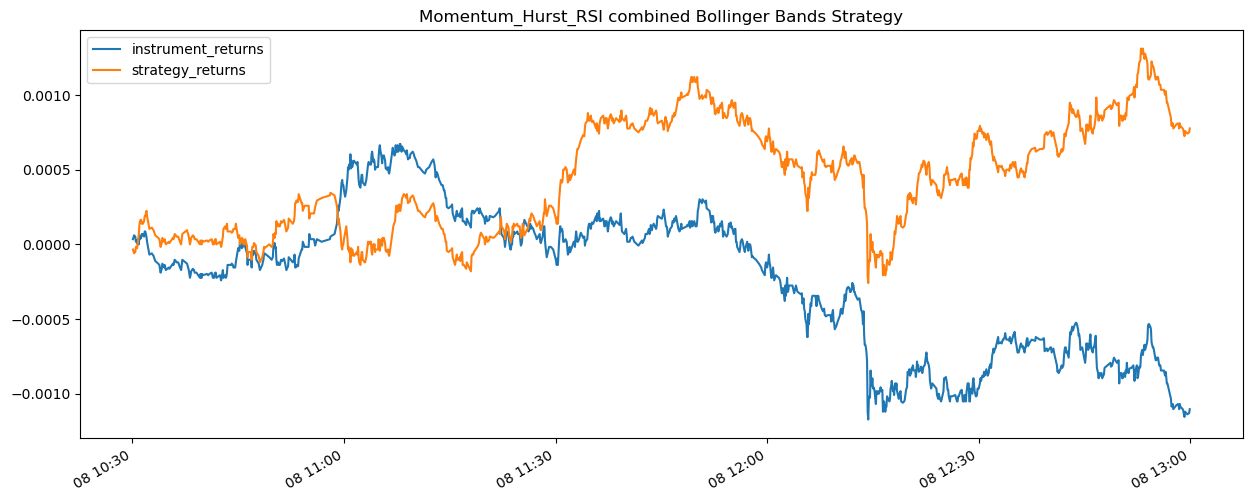

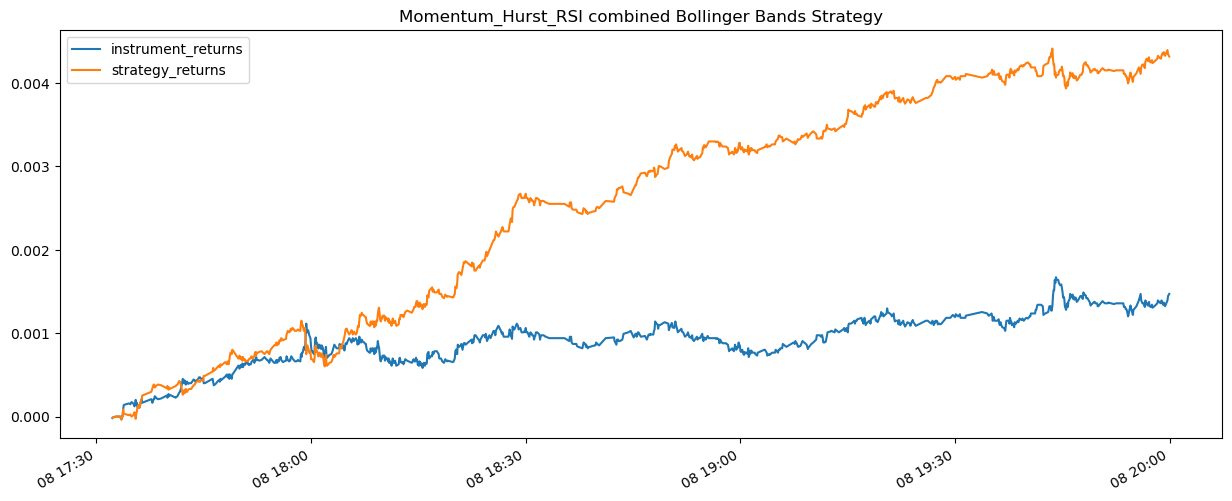

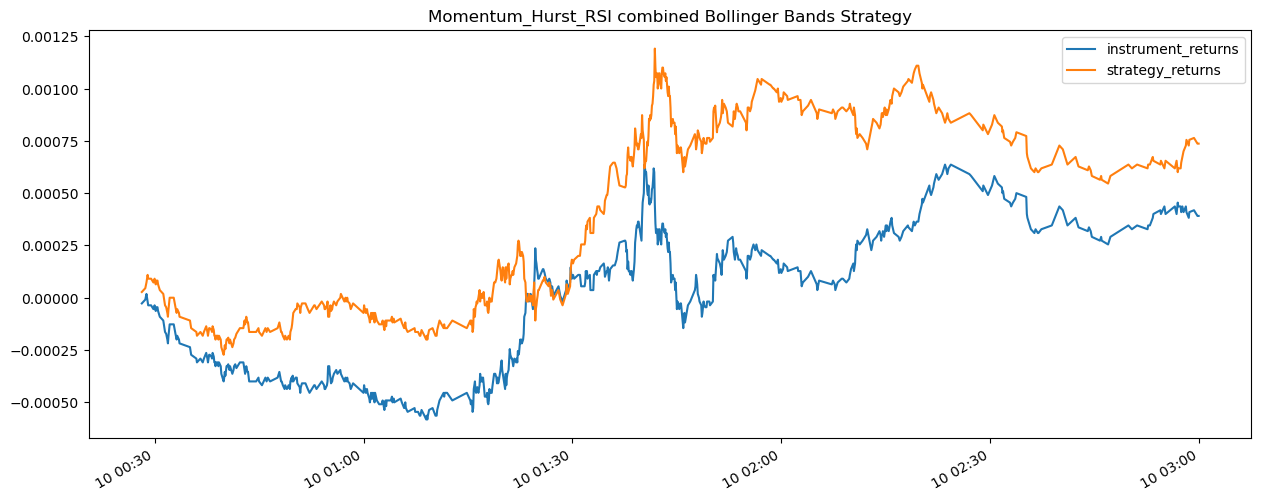

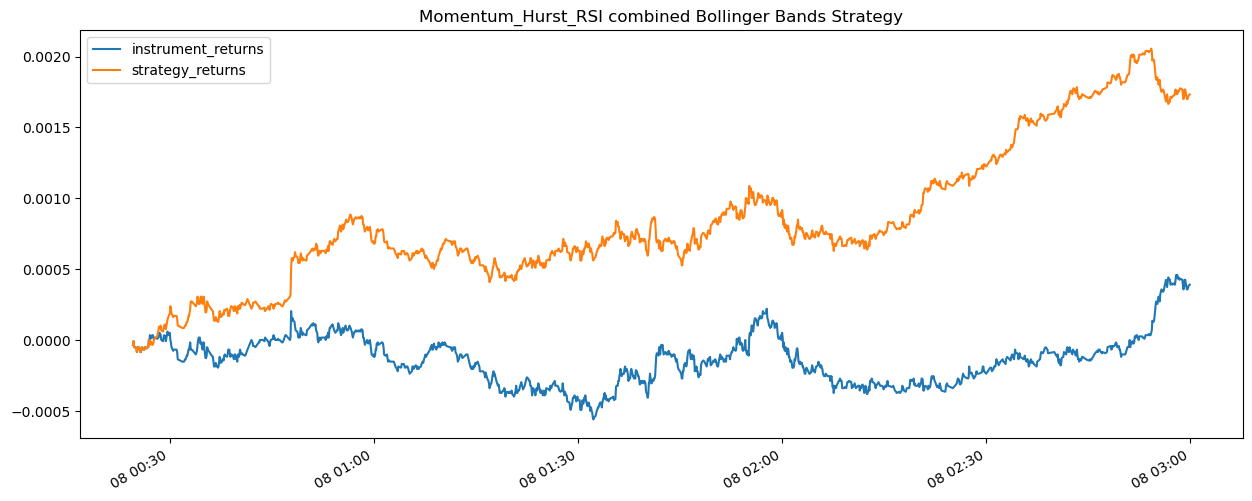

In [15]:
# Use multiple periods to do backtest
time_periods = [
    
    {"from": "2015-10-07T00:00:00Z", "to": "2015-10-07T03:00:00Z"},
    {"from": "2016-10-07T00:00:00Z", "to": "2016-10-07T03:00:00Z"},
    {"from": "2017-11-08T10:00:00Z", "to": "2017-11-08T13:00:00Z"},
    {"from": "2018-10-08T17:00:00Z", "to": "2018-10-08T20:00:00Z"},
    {"from": "2019-10-10T00:00:00Z", "to": "2019-10-10T03:00:00Z"},
    {"from": "2020-10-08T00:00:00Z", "to": "2020-10-08T03:00:00Z"},
    # can add more periods to backtest
]

# Keep other parameters unchanged
instrument = "EUR_USD"
granularity = "S5"
price = "M"


for i, period in enumerate(time_periods):
    results = pd.DataFrame()

    print('-------------------')
    print(f'Running the Strategy for period: {i+1}')
    print(f"From: {period['from']}, To: {period['to']}")
    print('-------------------')
    
    # update params
    params = {
        "from": period['from'],
        "to": period['to'],
        "granularity": "S5",
        "price": 'M'
    }
    
    momentum_hurst_rsi_bb = Momentum_Hurst_RSI_BB(instrument, params, 5, 21, 200, 20, 0.8)
    momentum_hurst_rsi_bb.strategy()
    


    results[f'instrument_returns'] = momentum_hurst_rsi_bb.visualise_data['Instrument_Returns']
    results[f'strategy_returns'] = momentum_hurst_rsi_bb.visualise_data['Strategy_Returns']

    results['instrument_returns'] = pd.to_numeric(results['instrument_returns'], errors='coerce')
    results['strategy_returns'] = pd.to_numeric(results['strategy_returns'], errors='coerce')


    plot_title = 'Momentum_Hurst_RSI combined Bollinger Bands Strategy'
    results.cumsum().plot(title=plot_title, figsize=(15, 6))
    calculate_metrics(results['instrument_returns'], 'Instrument Returns', 0)
    calculate_metrics(results['strategy_returns'], 'Strategy Returns', 0)

We can see that for the six periods, the strategy all performs better than the market so we finished the fine-tuning parts and set parameters = 0.8

## Validate our strategy on test period:2021-2022

-------------------
Running the Strategy for period: 1
From: 2021-10-07T00:00:00Z, To: 2021-10-07T03:00:00Z
-------------------
Annual Regular Return (Instrument Returns): -0.00011499190023334105
Annual Regular Standard Deviation (Instrument Returns): 0.0008923376472265431
Annual Regular Downside Standard Deviation Under Target Return=0 (Instrument Returns): 0.001036064130432077
Sharpe Ratio (Instrument Returns): -0.12886590697001868
Sortino Ratio (Instrument Returns): -0.11099555416602475
-----
Annual Regular Return (Strategy Returns): 0.0021538117717940786
Annual Regular Standard Deviation (Strategy Returns): 0.0008910531880051676
Annual Regular Downside Standard Deviation Under Target Return=0 (Strategy Returns): 0.0010280963391687188
Sharpe Ratio (Strategy Returns): 2.4171528712173664
Sortino Ratio (Strategy Returns): 2.092698478074352
-----
-------------------
Running the Strategy for period: 2
From: 2021-10-07T04:00:00Z, To: 2021-10-07T06:00:00Z
-------------------
Annual Regular

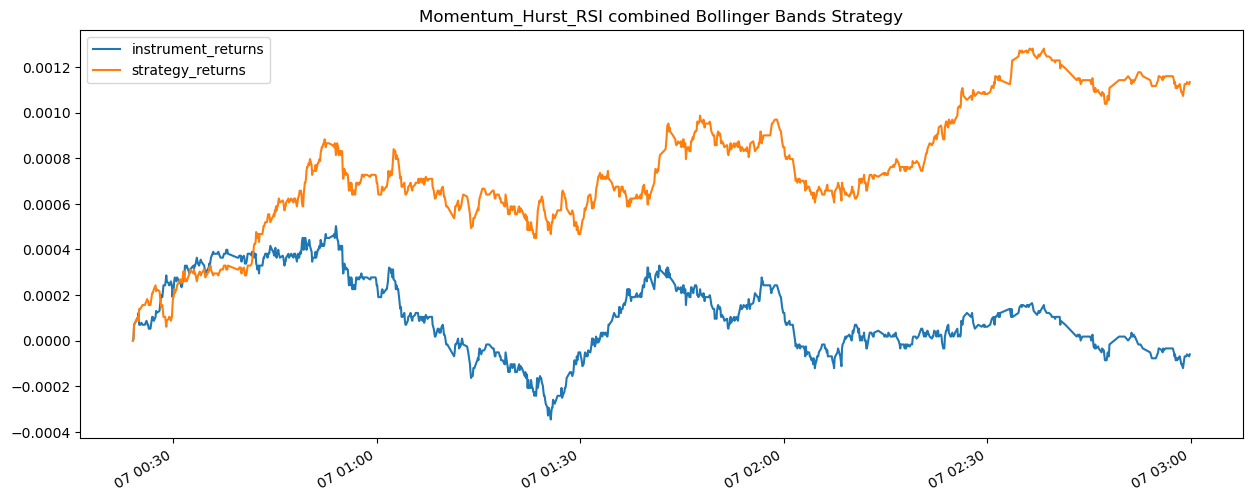

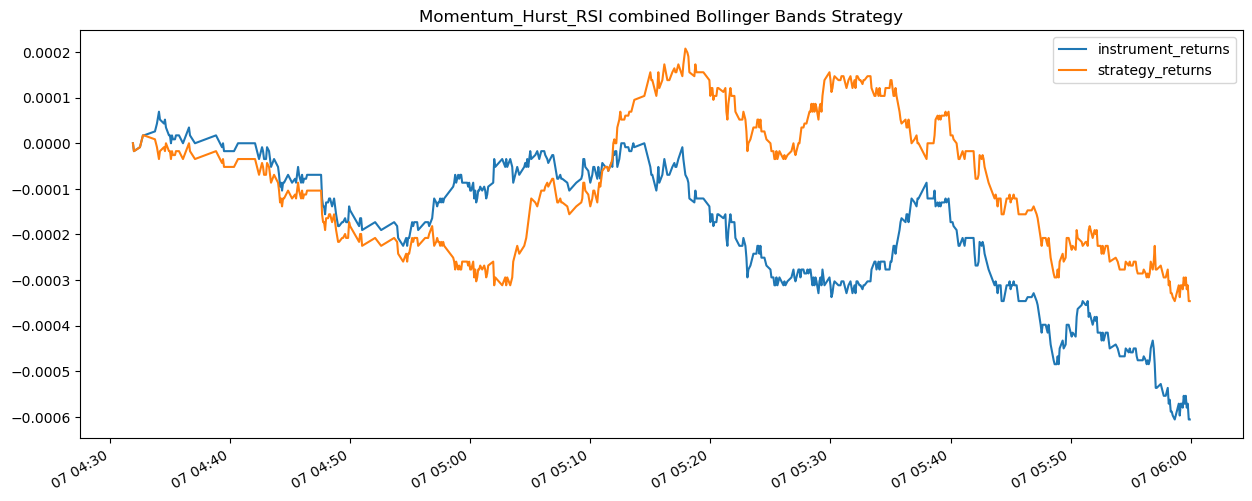

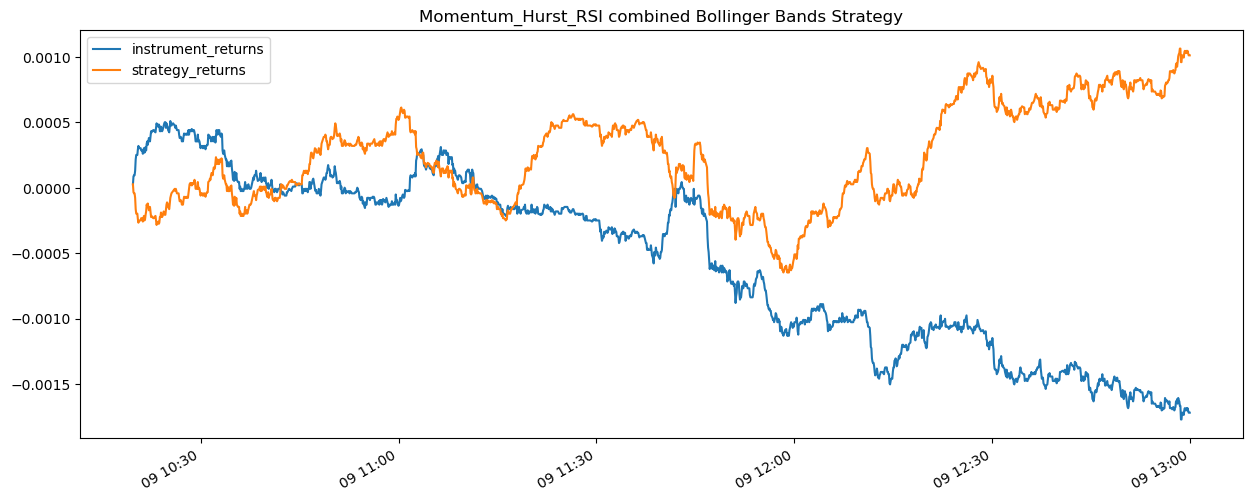

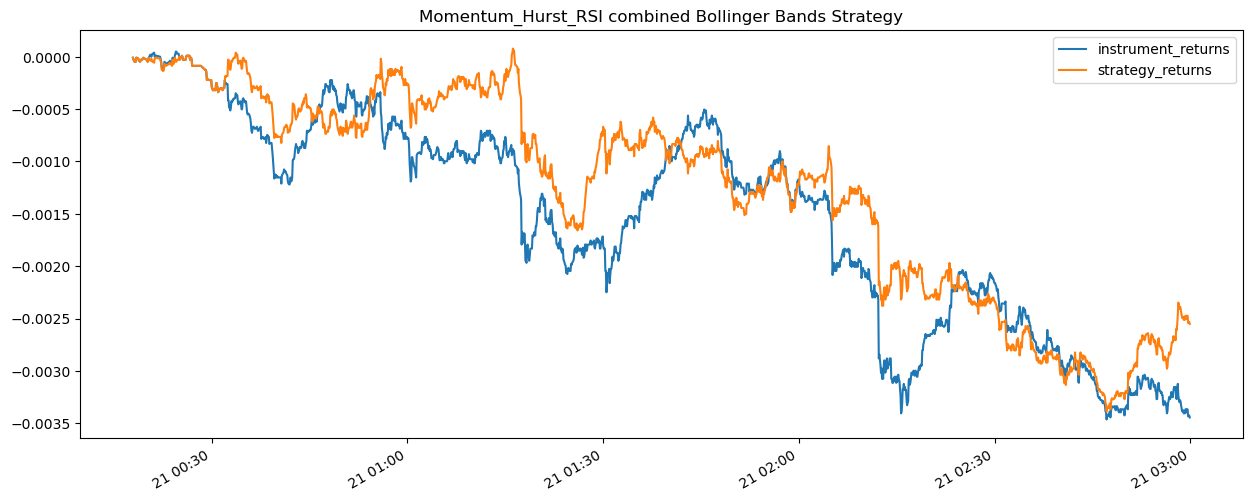

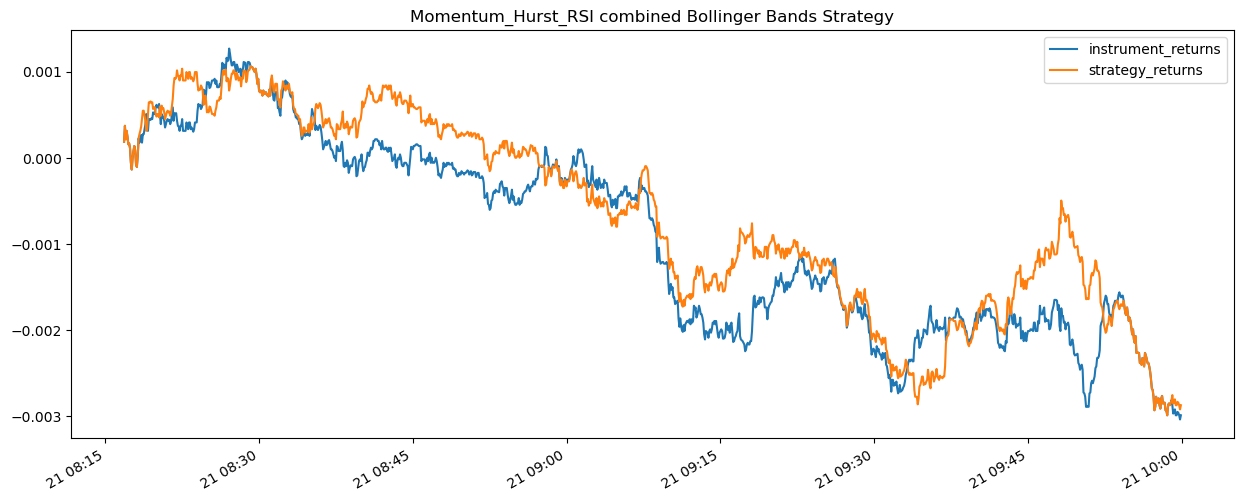

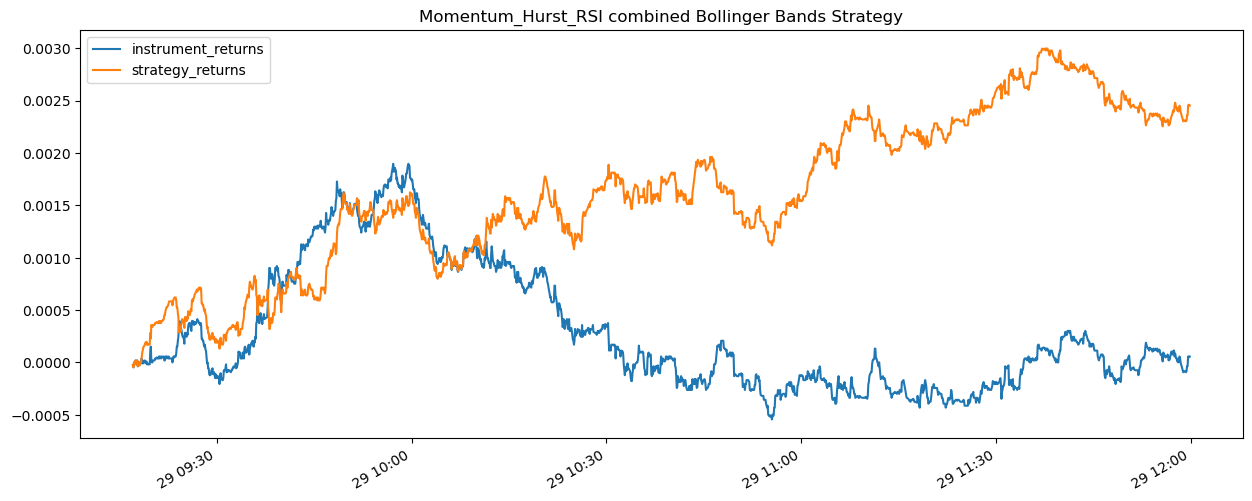

In [48]:
# Use multiple periods to do backtest
time_periods = [
    
    {"from": "2021-10-07T00:00:00Z", "to": "2021-10-07T03:00:00Z"},
    {"from": "2021-10-07T04:00:00Z", "to": "2021-10-07T06:00:00Z"},
    {"from": "2021-11-09T10:00:00Z", "to": "2021-11-09T13:00:00Z"},
    {"from": "2022-11-21T00:00:00Z", "to": "2022-11-21T03:00:00Z"},
    {"from": "2022-11-21T08:00:00Z", "to": "2022-11-21T10:00:00Z"},
    {"from": "2022-12-29T09:00:00Z", "to": "2022-12-29T12:00:00Z"},
    # can add more periods to backtest
]

# Keep other parameters unchanged
instrument = "EUR_USD"
granularity = "S5"
price = "M"


for i, period in enumerate(time_periods):
    results = pd.DataFrame()

    print('-------------------')
    print(f'Running the Strategy for period: {i+1}')
    print(f"From: {period['from']}, To: {period['to']}")
    print('-------------------')
    
    # update params
    params = {
        "from": period['from'],
        "to": period['to'],
        "granularity": "S5",
        "price": 'M'
    }
    
    momentum_hurst_rsi_bb = Momentum_Hurst_RSI_BB(instrument, params, 5, 21, 200, 20, 0.8)
    momentum_hurst_rsi_bb.strategy()
    


    results[f'instrument_returns'] = momentum_hurst_rsi_bb.visualise_data['Instrument_Returns']
    results[f'strategy_returns'] = momentum_hurst_rsi_bb.visualise_data['Strategy_Returns']

    results['instrument_returns'] = pd.to_numeric(results['instrument_returns'], errors='coerce')
    results['strategy_returns'] = pd.to_numeric(results['strategy_returns'], errors='coerce')


    plot_title = 'Momentum_Hurst_RSI combined Bollinger Bands Strategy'
    results.cumsum().plot(title=plot_title, figsize=(15, 6))
    calculate_metrics(results['instrument_returns'], 'Instrument Returns', 0)
    calculate_metrics(results['strategy_returns'], 'Strategy Returns', 0)

The strategy works not bad for the validation periods after fine-tuning so we will deploy the strategy for real-time trading.